### Introduction
This notebook explores Spark MLlib by taking an example of house price regression.

The dataset used within this notebook is California housing price, which can be downloaded from [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices?select=housing.csv).

First, we create a SparkSession object that executes all DataFrame API.

In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession
         .builder
         .appName('Housing price regression')
         .getOrCreate())

Load the dataset using Spark DataFrameReader.

In [25]:
RANDOM_SEED = 42
csv_file = '../datasets/housing.csv'

In [26]:
houseDF = (spark
           .read
           .format('com.databricks.spark.csv')
           .option('header', 'true')
           .option('inferSchema', 'true')
           .load(csv_file))

houseDF.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



Split the dataset into training and testset with the proportion 4 : 1.

In [126]:
houseDF.cache()
trainDF, testDF = houseDF.randomSplit([.8, .2], seed=RANDOM_SEED)

### Exploratory data analysis

In [127]:
%matplotlib inline
import pandas as pd
import pyspark.sql.dataframe as pdf
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist
import seaborn as sns
from pprint import pprint

Overall schema of the training set

In [29]:
print(trainDF.printSchema())

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

None


In [30]:
numeric_cols = [c for c,t in trainDF.dtypes if t == 'double']
string_cols = [c for c,t in trainDF.dtypes if t == 'string']

Check missing values

In [32]:
def get_missing_values(df: pdf.DataFrame) -> dict:
    missing_values = {}
    for c in df.columns:
        missing_count = (df
                         .select(c)
                         .filter(F.col(c).eqNullSafe(None) |
                                 F.col(c).isNull())
                         .count())
        missing_values[c] = missing_count
    return missing_values

missing_values = get_missing_values(trainDF)
pd.DataFrame([missing_values]).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,0,0,0,157,0,0,0,0,0


Records that miss `total_bedrooms` information

In [34]:
(trainDF
 .where(F.col('total_bedrooms').isNull())
 .show(3))

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -124.13|   40.55|              38.0|      544.0|          null|     240.0|      91.0|         3.25|           94800.0|      <1H OCEAN|
|  -124.06|   40.86|              34.0|     4183.0|          null|    1891.0|     669.0|       3.2216|           98100.0|     NEAR OCEAN|
|   -124.0|   40.92|              29.0|     1429.0|          null|     672.0|     266.0|       2.9485|           98800.0|      <1H OCEAN|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



Summary statistics

In [9]:
print('Summary statistics of numeric columns')
(trainDF
 .select(numeric_cols)
 .summary()
 .show())

Summary statistics of numeric columns
+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|summary|         longitude|         latitude|housing_median_age|      total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|
+-------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             16560|            16560|             16560|            16560|             16403|             16560|            16560|             16560|             16560|
|   mean|-119.5842886473419|35.65215519323691|28.634722222222223|2629.759963768116| 536.9965859903676| 1420.209963768116|498.7530193236715| 3.852551225845424|205596.39806763286|
| stddev| 2.007848863288596|2.144785065244251|12.589563031817192|2173.91

In [10]:
print('Summary statistics of string columns')
(trainDF
 .select(string_cols)
 .groupBy(string_cols)
 .count()
 .show())

Summary statistics of string columns
+---------------+-----+
|ocean_proximity|count|
+---------------+-----+
|         ISLAND|    4|
|     NEAR OCEAN| 2117|
|       NEAR BAY| 1855|
|      <1H OCEAN| 7268|
|         INLAND| 5316|
+---------------+-----+



Distribution of individual columns

In [11]:
def plot_single_histogram(df, col, bins=30):
    fig, ax = plt.subplots()
    hist(axis=ax, x=df
           .select(col), bins=bins)
    ax.set_xlabel(col)

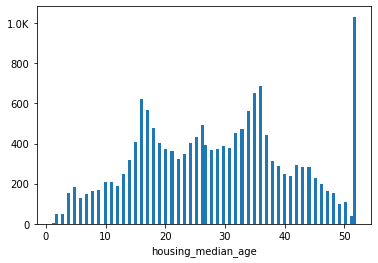

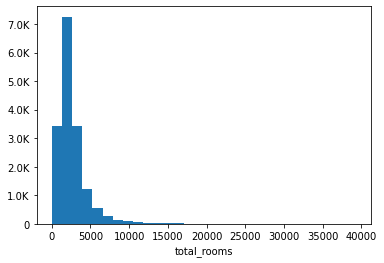

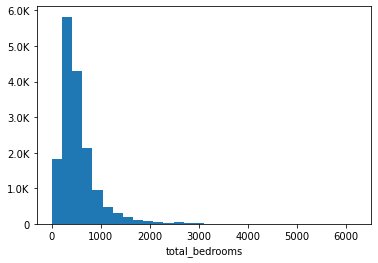

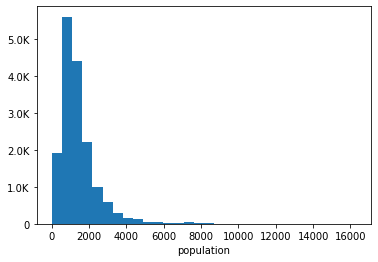

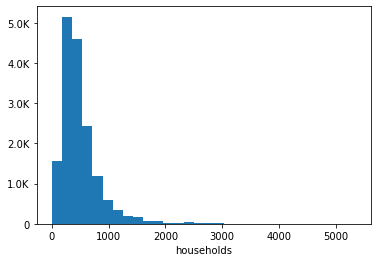

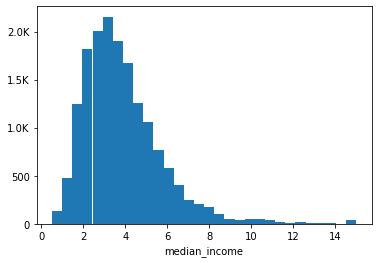

In [128]:
plot_single_histogram(trainDF, 'housing_median_age', bins=100)
plot_single_histogram(trainDF, 'total_rooms')
plot_single_histogram(trainDF, 'total_bedrooms')
plot_single_histogram(trainDF, 'population')
plot_single_histogram(trainDF, 'households')
plot_single_histogram(trainDF, 'median_income')

Some observations:
* The distribution of counting numbers (e.g. `total_rooms`, `total_bedrooms`, `populations`, `households`) are right-skewed.

* The distribution of `median_income` is also right-skewed, showing that a small population get very high income compared to the rest.
* There is a peak in the histogram of `housing_median_age` locating at 52. This might be due to the conversion of large ages to this value.

Next, let's inspect the correlation among columns.

<AxesSubplot:>

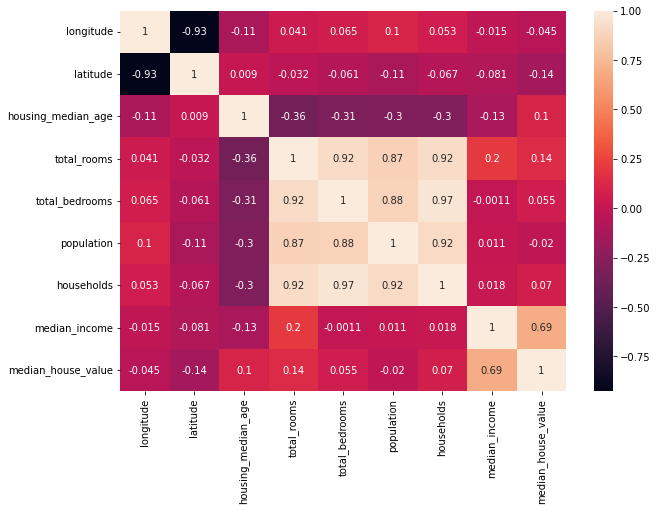

In [129]:
trainDF.corr('housing_median_age', 'median_house_value')
def correlation_matrix(df, columns):
    n = len(columns)
    mat = np.eye(n)
    for i in range(n-1):
        for j in range(i+1, n):
            mat[j, i] = mat[i, j] = df.corr(columns[i], columns[j])
    return mat

corrDF = pd.DataFrame(
    correlation_matrix(trainDF, numeric_cols),
    columns=numeric_cols,
    index=numeric_cols
)
plt.figure(figsize = (10,7))
sns.heatmap(corrDF, annot=True)

The house value is highly correlated to `median_income` which truely makes sense.

### Model building

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

predict_col = 'prediction'
label = 'median_house_value'

def evaluate(df, predict_col, label, metric='rmse'):
    regressionEvaluator = RegressionEvaluator(
        predictionCol=predict_col,
        labelCol=label,
        metricName=metric)
    return regressionEvaluator.evaluate(df)

We select Root Mean Square Error (RMSE) as the evaluation metric.

First, let's build a simple model that predicts median house value as the average value on the training set. This baseline model achieves `117625.94` RMSE.

In [130]:
prediction_bl = testDF.select(F.mean(F.col('median_house_value'))).take(1)[0][0]
testDF_bl = testDF.withColumn('prediction', F.lit(prediction_bl))
print('RMSE (baseline): %.2f' % evaluate(testDF_bl, predict_col, label))

RMSE (baseline): 117625.94


The simple model does not take any other information except the target column. While the target is correlated to other columns as well, the exploitation of other columns would result in a more accurate model. Otherwise, we are on the wrong track.


Let's first consider a linear regression model that predicts median house value using:
* `log of total_rooms`
* `housing_median_age`

The use of logarithmic transform is to mitigate the right tail of `total_rooms` and expand its left tail, making `total_rooms` more normally distributed.


In [40]:
from pyspark.ml import Pipeline, Transformer, Estimator
from pyspark.ml.feature import (VectorAssembler,
                                StandardScaler,
                                StringIndexer,
                                OneHotEncoder,
                                Imputer,
                                Interaction,
                                QuantileDiscretizer)
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression


class LogTransform(Transformer):
    """
    Perform logarithm transform for a set of columns
    """
    def __init__(self, inputCols: list, outputCols: list):
        if not isinstance(inputCols, list):
            inputCols = [inputCols]
        if not isinstance(outputCols, list):
            outputCols = [outputCols]

        assert len(inputCols) == len(outputCols), \
            print('The number of input and output columns do not match')
        self.inputCols, self.outputCols = inputCols, outputCols
        super().__init__()

    def _transform(self, df: pdf.DataFrame) -> pdf.DataFrame:
        for c_in, c_out in zip(self.inputCols, self.outputCols):
            df = df.withColumn(c_out, F.log(F.col(c_in) + 1))
        return df

In [60]:
def get_lr_pipeline(transformers: list,
                    input_features: list,
                    label_col: str='label',
                    predict_col: str='prediction') -> Pipeline:
    vec_assembler = VectorAssembler(inputCols=input_features,
                                    outputCol='features')
    scaler = StandardScaler(inputCol=vec_assembler.getOutputCol(),
                            outputCol="scaled_features",
                            withMean=True, withStd=True)
    lr = LinearRegression(labelCol=label_col,
                          predictionCol=predict_col,
                          featuresCol="scaled_features",
                          standardization=False)
    pipeline = Pipeline(stages=transformers + [vec_assembler, scaler, lr])
    return pipeline



log_trans = LogTransform(inputCols=['total_rooms'],
                         outputCols=['log_total_rooms'])
pipeline = get_lr_pipeline(transformers=[log_trans],
                           input_features=['log_total_rooms',
                                           'housing_median_age'],
                           label_col=label,
                           predict_col=predict_col)
model = pipeline.fit(trainDF)
testDF_lr = model.transform(testDF)
print('RMSE (linear regression - 2 features): %.2f' % evaluate(testDF_lr, predict_col, label))
print('R2 (linear regression - 2 features): %.2f' % evaluate(testDF_lr, predict_col, label, metric='r2'))

RMSE (linear regression - 2 features): 114732.75
R2 (linear regression - 2 features): 0.05


We see that linear regression with two features slightly improves RMSE of the baseline from `117625.94` to `114732.75`. Also noted that, `R2` is another metric that quantifies the improvement compared to the baseline. The larger of `R2`, the more improvement.

Now we add one-hot encoding of `ocean_proximity`, an expressive feature that might influence the house price.
* `log of total_rooms`
* `housing_median_age`
* `ocean_proximity`

In [61]:
string_indexer = StringIndexer(inputCols=['ocean_proximity'],
                               outputCols=['ocean_proximity_index'])
oh_encoder = OneHotEncoder(inputCols=['ocean_proximity_index'],
                           outputCols=['ocean_proximity_oh'])
pipeline = get_lr_pipeline(transformers=[log_trans,
                                         string_indexer,
                                         oh_encoder],
                           input_features=['log_total_rooms',
                                           'housing_median_age',
                                           'ocean_proximity_oh'],
                           label_col=label,
                           predict_col=predict_col)
model = pipeline.fit(trainDF)

testDF_lr = model.transform(testDF)
print('RMSE (linear regression - 3 features): %.2f' % evaluate(testDF_lr, predict_col, label))
print('R2 (linear regression - 3 features): %.2f' % evaluate(testDF_lr, predict_col, label, metric='r2'))

RMSE (linear regression - 3 features): 101085.70
R2 (linear regression - 3 features): 0.26


The error reduces to `101085.70`, and `R2` increases to `0.26`.

In the following, we incrementally add meaning features and observe continous improvements.

Linear regression using:
* `log of total_rooms`
* `housing_median_age`
* `ocean_proximity`
* `log of median_income`

In [62]:
log_trans = LogTransform(inputCols=['total_rooms', 'median_income'],
                         outputCols=['log_total_rooms', 'log_median_income'])

pipeline = get_lr_pipeline(transformers=[log_trans,
                                         string_indexer,
                                         oh_encoder],
                           input_features=['log_total_rooms',
                                           'housing_median_age',
                                           'ocean_proximity_oh',
                                           'log_median_income'],
                           label_col=label,
                           predict_col=predict_col)
model = pipeline.fit(trainDF)

testDF_lr = model.transform(testDF)
print('RMSE (linear regression - 4 features): %.2f' % evaluate(testDF_lr, predict_col, label))
print('R2 (linear regression - 4 features): %.2f' % evaluate(testDF_lr, predict_col, label, metric='r2'))

RMSE (linear regression - 4 features): 75393.91
R2 (linear regression - 4 features): 0.59


Linear regression using:
* `log of total_rooms`
* `log of total_bedrooms`
* `housing_median_age`
* `ocean_proximity`
* `log of median_income`

In [63]:
imputer = Imputer(inputCols=['total_bedrooms'],
                  outputCols=['cleaned_total_bedrooms'])
log_trans = LogTransform(inputCols=['total_rooms', 'median_income', 'cleaned_total_bedrooms'],
                         outputCols=['log_total_rooms', 'log_median_income', 'log_cleaned_total_bedrooms'])
pipeline = get_lr_pipeline(transformers=[imputer,
                                         log_trans,
                                         string_indexer,
                                         oh_encoder],
                           input_features=['log_total_rooms',
                                           'log_cleaned_total_bedrooms',
                                           'housing_median_age',
                                           'ocean_proximity_oh',
                                           'log_median_income'],
                           label_col=label,
                           predict_col=predict_col)
model = pipeline.fit(trainDF)

testDF_lr = model.transform(testDF)
print('RMSE (linear regression - 5 features): %.2f' % evaluate(testDF_lr, predict_col, label))
print('R2 (linear regression - 5 features): %.2f' % evaluate(testDF_lr, predict_col, label, metric='r2'))

RMSE (linear regression - 5 features): 74415.49
R2 (linear regression - 5 features): 0.60


Linear regression using
* `log of total_rooms`
* `log of total_bedrooms`
* `housing_median_age`
* `ocean_proximity`
* `log of median_income`
* `bucketed longitude x bucketed latitude`

In [64]:
bucketizer = QuantileDiscretizer(numBuckets=10,
                                 inputCols=['longitude', 'latitude'],
                                 outputCols=['bucketed_longitude', 'bucketed_latitude'])

interaction = Interaction(inputCols=['bucketed_longitude', 'bucketed_latitude'],
                          outputCol='bucketed_longitude_x_bucketed_latitude')
pipeline = get_lr_pipeline(transformers=[imputer,
                                         bucketizer,
                                         interaction,
                                         log_trans,
                                         string_indexer,
                                         oh_encoder],
                           input_features=['log_total_rooms',
                                           'log_cleaned_total_bedrooms',
                                           'housing_median_age',
                                           'ocean_proximity_oh',
                                           'log_median_income',
                                           'bucketed_longitude_x_bucketed_latitude'],
                           label_col=label,
                           predict_col=predict_col)
model = pipeline.fit(trainDF)

testDF_lr = model.transform(testDF)
print('RMSE (linear regression - 6 features): %.2f' % evaluate(testDF_lr, predict_col, label))
print('R2 (linear regression - 6 features): %.2f' % evaluate(testDF_lr, predict_col, label, metric='r2'))


RMSE (linear regression - 6 features): 64984.41
R2 (linear regression - 6 features): 0.69


We have used of six features, including:
* `log of total_rooms`
* `log of total_bedrooms`
* `housing_median_age`
* `ocean_proximity`
* `log of median_income`
* `bucketed longitude x bucketed latitude`

Machine learning pipelines are concerned with hyperparameters, for instance: imputation strategry for `total_bedrooms`, regularization of linear regression, number of buckets for discretizing `longitude` and `latitude`.

Spark provides efficient cross-validation pipeline for hyperparamter tuning. In the following, we perform grid search in hyperparameter space to select the best model.

In [134]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

def get_cv_pipeline(transformers: list,
                    input_features: list,
                    estimator: Estimator,
                    param_grid: list,
                    label_col: str='label',
                    predict_col: str='prediction',
                    metric: str='rmse',
                    num_fold: int=5) -> CrossValidator:
    vec_assembler = VectorAssembler(inputCols=input_features,
                                    outputCol='features')
    scaler = StandardScaler(inputCol=vec_assembler.getOutputCol(),
                            outputCol="scaled_features")
    pipeline = Pipeline(stages=transformers + [vec_assembler, scaler, estimator])

    evaluator = RegressionEvaluator(
        predictionCol=predict_col,
        labelCol=label_col,
        metricName=metric)

    cv = CrossValidator(estimator=pipeline,
                        evaluator=evaluator,
                        estimatorParamMaps=param_grid,
                        numFolds=num_fold,
                        seed=RANDOM_SEED,
                        parallelism=4)

    return cv

In [135]:
lr = LinearRegression(predictionCol=predict_col,
                      labelCol=label,
                      featuresCol='scaled_features',
                      standardization=False)

param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0, 0.1, 0.01, 0.001])
              .addGrid(lr.elasticNetParam, [0, 0.5, 1])
              .addGrid(imputer.strategy, ['mean', 'median', 'mode'])
              .addGrid(bucketizer.numBuckets, [5, 10, 15])
              .build())
pipeline = get_cv_pipeline(transformers=[imputer,
                                         bucketizer,
                                         interaction,
                                         log_trans,
                                         string_indexer,
                                         oh_encoder],
                           input_features=['log_total_rooms',
                                           'log_cleaned_total_bedrooms',
                                           'housing_median_age',
                                           'ocean_proximity_oh',
                                           'log_median_income',
                                           'bucketed_longitude_x_bucketed_latitude'],
                           estimator=lr,
                           label_col=label,
                           predict_col=predict_col,
                           param_grid=param_grid,
                           num_fold=3)

import time
start = time.perf_counter()
model = pipeline.fit(trainDF)
print('HP tuning in: %.2f seconds' % (time.perf_counter()-start))

testDF_lr = model.transform(testDF)
print('RMSE (linear regression - 6 features - hyperparameter tuning): %.2f' % evaluate(testDF_lr, predict_col, label))
print('R2 (linear regression - 6 features - hyperparameter tuning): %.2f' % evaluate(testDF_lr, predict_col, label, metric='r2'))

cv_summaries = list(zip(model.getEstimatorParamMaps(), model.avgMetrics))
cv_summaries = sorted(cv_summaries, key=lambda x: x[-1])
print('\nBest hyperparameters: ')
pprint(cv_summaries[0])

HP tuning in: 319.81 seconds
RMSE (linear regression - 6 features - hyperparameter tuning): 62169.41
R2 (linear regression - 6 features - hyperparameter tuning): 0.72

Best hyperparameters: 
({Param(parent='LinearRegression_ca63ec10b4de', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
  Param(parent='Imputer_05cec1ca1f9b', name='strategy', doc='strategy for imputation. If mean, then replace missing values using the mean value of the feature. If median, then replace missing values using the median value of the feature. If mode, then replace missing using the most frequent value of the feature.'): 'mode',
  Param(parent='QuantileDiscretizer_e2b152b12689', name='numBuckets', doc='Maximum number of buckets (quantiles, or categories) into which data points are grouped. Must be >= 2.'): 15,
  Param(parent='LinearRegression_ca63ec10b4de', name='regParam', doc='regularizatio

The best set of hyperparameters:
- Imputation using mode of `total_bedrooms`
- No regularization (`regParam` = 0)
- 15 buckets for `longitude` and `latitude`

We finally obtained the best `RMSE = 62169.41`, and `R2 = 0.72`.

In [ ]:
houseDF.unpersist()
spark.stop()

END.
